In [2]:
%pip install scienceplots

Of course. The Ising model is one of the most fundamental and influential models in statistical physics. It's beautiful because it's incredibly simple to describe, yet it can explain a profound and complex phenomenon: phase transitions.
Let's break it down, from a simple analogy to the technical details.
1. The Simple Analogy: A Social Network of Opinionated People
Imagine a large group of people arranged in a grid, like a checkerboard. Each person can only hold one of two opinions on a topic: "Agree" (+1) or "Disagree" (-1).
There are two main forces at play:
Peer Pressure (Interaction): Each person wants to agree with their immediate neighbors. If your neighbors "Agree," you feel a strong pull to also "Agree." This creates order.
Individual Stubbornness (Temperature): Each person also has a certain amount of random, individualistic energy. The higher this energy, the more likely they are to flip their opinion randomly, ignoring their neighbors. This creates chaos and disorder.
The Ising model studies the battle between these two forces.
Low Temperature (Low Stubbornness): Peer pressure wins. If you start with a few people agreeing, that opinion will quickly spread, and soon you'll have large, uniform blocks of "Agree" or "Disagree." The whole group reaches a consensus.
High Temperature (High Stubbornness): Individualism wins. Everyone is flipping their opinion randomly. The grid looks like a mess of static, with no clear consensus. It's total chaos.
The most interesting part is what happens at a very specific, "critical" temperature. This is the phase transition. It's the tipping point where the system is perfectly balanced between order and chaos, and a tiny change can cause the entire group to suddenly form a consensus.
2. The Physics Context: Tiny Magnets
The Ising model was originally created to explain ferromagnetism.
Imagine a piece of iron. It's made of countless microscopic regions that act like tiny magnets. Each tiny magnet can point either "Up" (+1) or "Down" (-1). In physics, this property is called spin.
Spins: The fundamental units of the model. They are discrete variables, usually represented as s_i = +1 (spin up) or s_i = -1 (spin down).
Lattice: The spins are not floating freely; they are fixed in a rigid structure, or grid, called a lattice (e.g., a 1D line, a 2D square grid, or a 3D cube).
Interaction Energy (J): Spins interact with their nearest neighbors. The model assumes that aligned spins have lower energy (are more stable).
If J > 0 (ferromagnetic), neighboring spins want to point in the same direction (↑↑ or ↓↓). This is the lowest energy state.
If J < 0 (antiferromagnetic), neighboring spins want to point in opposite directions (↑↓).
External Magnetic Field (h): You can apply an external magnetic field that encourages all spins to align with it. For example, a positive field h will make the "Up" (+1) state have lower energy.
Temperature (T): This represents thermal energy or random fluctuations. It's the force of disorder that tries to flip the spins randomly, disrupting any alignment.
3. The Goal and The Math (The Hamiltonian)
The goal of the Ising model is to find the overall state of the system by calculating its total energy. This energy is described by a function called the Hamiltonian (H). The system will always try to settle into the state with the lowest possible energy.
The equation for the Hamiltonian looks like this:
H = -J Σ<sub><i,j></sub> s<sub>i</sub>s<sub>j</sub> - h Σ<sub>i</sub> s<sub>i</sub>
Let's break down this famous equation:
s_i and s_j: The spin values (+1 or -1) of two neighboring spins, i and j.
Σ<i,j>: This means "sum over all pairs of nearest neighbors."
-J s_i s_j: This is the interaction energy part.
If spins s_i and s_j are aligned (both +1 or both -1), then s_i * s_j = 1. The energy is -J. Since J is positive, this is a low energy state. The system is happy.
If spins are opposite (+1 and -1), then s_i * s_j = -1. The energy is +J. This is a high energy state. The system is unhappy.
h: The strength of the external magnetic field.
Σ_i s_i: This is the sum of all spins in the system, which is the total magnetization.
-h Σ_i s_i: This is the external field energy part. The system's energy is lowered if the spins align with the field h.
The battle is between the first term (ordering neighbors) and the random thermal energy (Temperature, T), which is not explicitly in the Hamiltonian but determines the probability of the system being in a certain state.
What Does The Ising Model Explain?
1. Phase Transitions: This is its greatest achievement. Just like water turns from liquid to ice at 0°C, the Ising model shows a magnetic material suddenly becoming magnetized below a specific Critical Temperature (T<sub>c</sub>).
* Above T<sub>c</sub>: Temperature (chaos) wins. The spins are randomly oriented. The net magnetization is zero. The material is a paramagnet.
* Below T<sub>c</sub>: Interaction (order) wins. The spins spontaneously align into large domains, creating a net magnetic field. The material becomes a ferromagnet.
This GIF shows a 2D Ising model simulation cooling down. At high temperatures (start), it's random. As it cools past the critical temperature, large domains of order (black or white) spontaneously form.
2. Spontaneous Symmetry Breaking: At high temperatures, the "Up" and "Down" directions are equally likely (symmetric). When the system cools below T<sub>c</sub>, it has to "choose" a direction to align with (mostly Up or mostly Down). It spontaneously breaks the initial symmetry.
Why is the Ising Model So Important?
Its applications go far beyond magnets. The core idea of simple, locally interacting units creating complex, large-scale behavior is universal. The Ising model is a prototype for:
Computer Science: Image denoising (is a pixel black or white based on its neighbors?).
Biology: Modeling neural networks (is a neuron firing or not?) or protein folding.
Economics & Social Science: Modeling opinion dynamics, financial markets (buy/sell), or urban segregation.
Lattice Gas Models: Simulating the transition between liquid and gas.
In essence, the Ising model is a powerful tool for thinking about any system where a competition between local cooperation and global randomness leads to emergent, collective behavior.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots # A nice plotting theme

plt.style.use(['science', 'notebook', 'grid'])


In [8]:
def loss_function(recon_x, x, mu, logvar):
    """VAE loss function: Reconstruction Loss + KL Divergence."""
    # Reconstruction loss (Binary Cross-Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, L*L), reduction='sum')

    # KL divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
# ===================================================================
# PART 1: THE VARIATIONAL AUTOENCODER (VAE)
# ===================================================================

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # To output values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [10]:
def calculate_energy(config, L):
    """Calculates the total energy of a given spin configuration."""
    total_energy = 0
    for i in range(L):
        for j in range(L):
            # Interaction with right neighbor (with periodic boundary conditions)
            total_energy -= config[i, j] * config[i, (j + 1) % L]
            # Interaction with bottom neighbor (with periodic boundary conditions)
            total_energy -= config[i, j] * config[(i + 1) % L, j]
    return total_energy

def metropolis_step(config, L, T):
    """Performs a single Metropolis-Hastings update."""
    # 1. Choose a random spin to flip
    i, j = np.random.randint(0, L, size=2)

    # 2. Calculate the change in energy if we flip this spin
    # Due to periodic boundaries, neighbors are (i, j-1), (i, j+1), (i-1, j), (i+1, j)
    neighbors_sum = (config[i, (j - 1) % L] + config[i, (j + 1) % L] +
                     config[(i - 1) % L, j] + config[(i + 1) % L, j])

    delta_E = 2 * config[i, j] * neighbors_sum

    # 3. Accept or reject the flip
    if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
        config[i, j] *= -1 # Flip the spin

def generate_ising_data(L, n_samples_per_T, temps):
    """Generates a dataset of Ising configurations across a range of temperatures."""
    all_configs = []
    all_temps = []
    all_mags = []

    print("Generating Ising model data with MCMC...")
    for T in tqdm(temps):
        # Start with a random configuration
        config = np.random.choice([-1, 1], size=(L, L))

        # Thermalize the system (run MCMC for a while to reach equilibrium)
        for _ in range(5000):
            metropolis_step(config, L, T)

        # Collect samples
        for _ in range(n_samples_per_T):
            # Run a few steps between samples to ensure they are less correlated
            for _ in range(100):
                 metropolis_step(config, L, T)

            all_configs.append(config.copy())
            all_temps.append(T)
            # Magnetization is the average spin
            all_mags.append(np.mean(config))

    # Convert to numpy arrays, map spins {-1, 1} to {0, 1} for VAE training
    # BCE loss works better with {0, 1}
    all_configs_np = (np.array(all_configs) + 1) / 2
    return all_configs_np, np.array(all_temps), np.array(all_mags)

Generating Ising model data with MCMC...


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]



Training the VAE...
====> Epoch:   1 Average loss: 153.1762
====> Epoch:   2 Average loss: 125.2134
====> Epoch:   3 Average loss: 122.1931
====> Epoch:   4 Average loss: 118.4261
====> Epoch:   5 Average loss: 116.9792
====> Epoch:   6 Average loss: 116.1608
====> Epoch:   7 Average loss: 115.5866
====> Epoch:   8 Average loss: 115.2437
====> Epoch:   9 Average loss: 114.7981
====> Epoch:  10 Average loss: 114.4892
====> Epoch:  11 Average loss: 114.1215
====> Epoch:  12 Average loss: 114.0029
====> Epoch:  13 Average loss: 113.7571
====> Epoch:  14 Average loss: 113.6033
====> Epoch:  15 Average loss: 113.5664
====> Epoch:  16 Average loss: 113.4566
====> Epoch:  17 Average loss: 113.1803
====> Epoch:  18 Average loss: 113.0901
====> Epoch:  19 Average loss: 112.9986
====> Epoch:  20 Average loss: 112.9278
====> Epoch:  21 Average loss: 112.7439
====> Epoch:  22 Average loss: 112.7046
====> Epoch:  23 Average loss: 112.6180
====> Epoch:  24 Average loss: 112.4758
====> Epoch:  25 Av

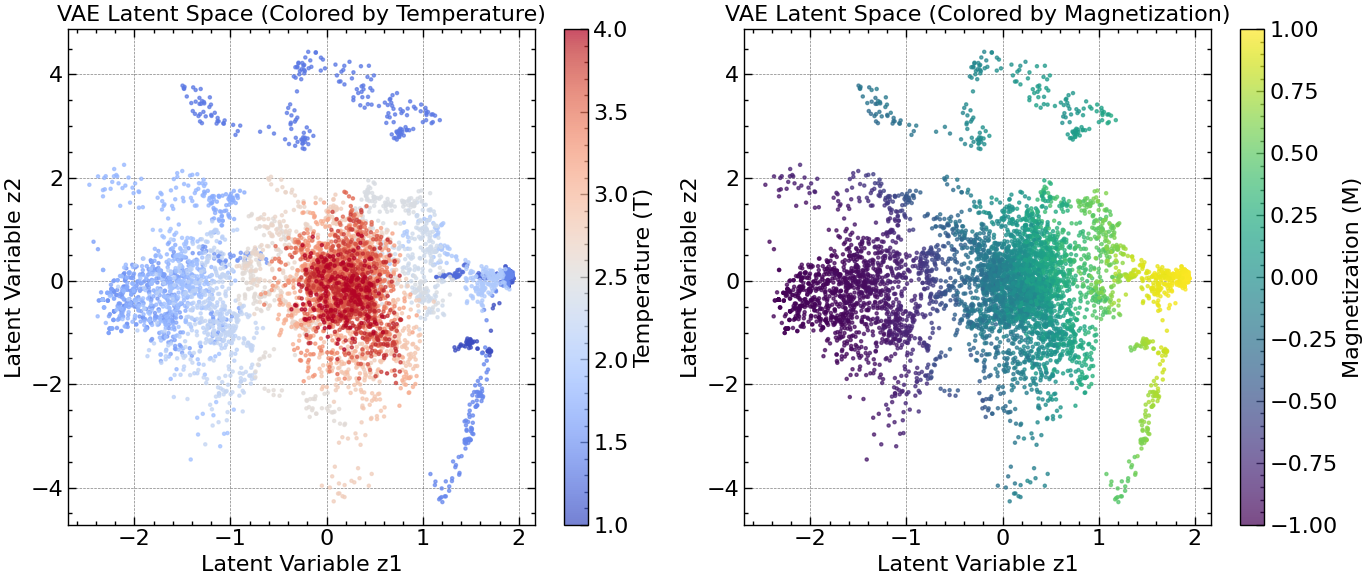


Visualizing some real training samples for comparison...


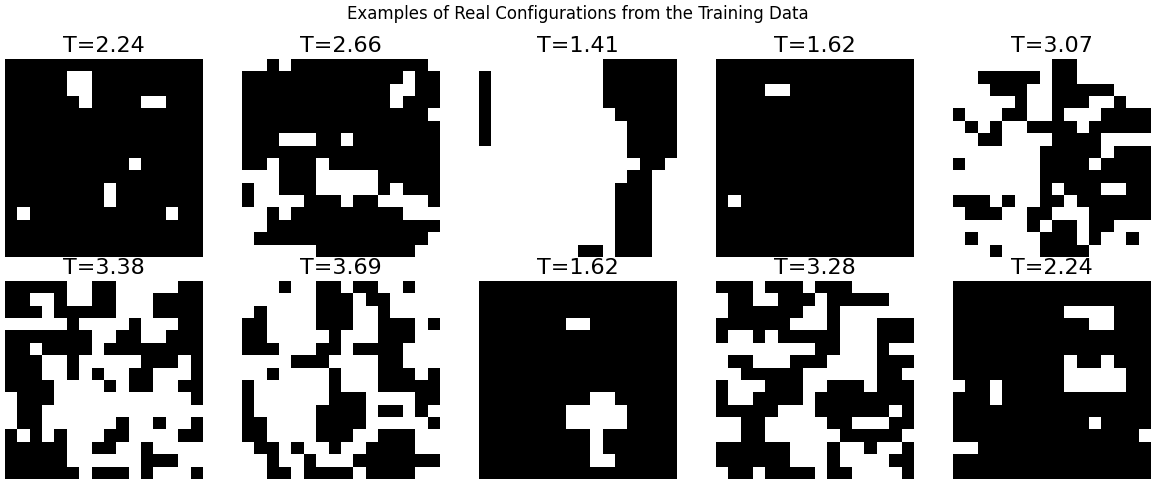


Generating new configurations from the latent space...


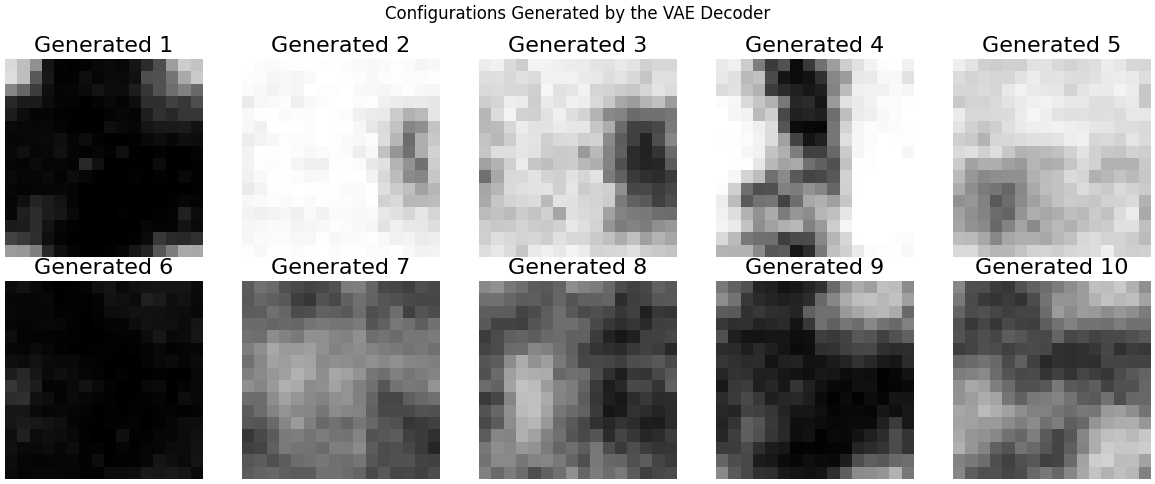

In [13]:
# ===================================================================
# PART 3: TRAINING AND ANALYSIS
# ===================================================================

if __name__ == '__main__':
    # --- 1. System and Training Parameters ---
    L = 16  # Lattice size (L x L)
    input_dim = L * L
    hidden_dim = 128
    latent_dim = 2   # We use 2D latent space for easy visualization
    epochs = 50      # Increased epochs for better convergence
    batch_size = 64
    learning_rate = 1e-3

    # The critical temperature for the 2D Ising model is ~2.269
    # We will sample temperatures around this critical point.
    temps = np.linspace(1.0, 4.0, 30)
    n_samples_per_T = 200

    # --- 2. Generate Data ---
    configs, ts, mags = generate_ising_data(L, n_samples_per_T, temps)

    # Create PyTorch DataLoader
    dataset = TensorDataset(torch.from_numpy(configs).float())
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- 3. Initialize Model and Optimizer ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # --- 4. Train the VAE ---
    print("\nTraining the VAE...")
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(data_loader.dataset)
        print(f'====> Epoch: {epoch+1:3d} Average loss: {avg_loss:.4f}')

    # --- 5. Analyze the Learned Latent Space ---
    print("\nAnalyzing the latent space...")
    model.eval()

    # Get the latent space representation (mu) for the entire dataset
    all_data_tensor = torch.from_numpy(configs).float().to(device)
    with torch.no_grad():
        latent_mu, _ = model.encode(all_data_tensor.view(-1, input_dim))

    latent_mu = latent_mu.cpu().numpy()

    # --- 6. Plotting Latent Space Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Latent space colored by Temperature
    sc1 = ax1.scatter(latent_mu[:, 0], latent_mu[:, 1], c=ts, cmap='coolwarm', s=5, alpha=0.7)
    ax1.set_title('VAE Latent Space (Colored by Temperature)')
    ax1.set_xlabel('Latent Variable z1')
    ax1.set_ylabel('Latent Variable z2')
    fig.colorbar(sc1, ax=ax1, label='Temperature (T)')

    # Plot 2: Latent space colored by Magnetization
    sc2 = ax2.scatter(latent_mu[:, 0], latent_mu[:, 1], c=mags, cmap='viridis', s=5, alpha=0.7)
    ax2.set_title('VAE Latent Space (Colored by Magnetization)')
    ax2.set_xlabel('Latent Variable z1')
    ax2.set_ylabel('Latent Variable z2')
    fig.colorbar(sc2, ax=ax2, label='Magnetization (M)')

    plt.tight_layout()
    plt.show()


    # --- 6b. Visualize Real Training Samples ---
    print("\nVisualizing some real training samples for comparison...")
    fig_real, axes_real = plt.subplots(2, 5, figsize=(12, 5))
    axes_real = axes_real.flatten()

    # Randomly select 10 indices from the dataset to display
    num_total_configs = configs.shape[0]
    random_indices = np.random.choice(num_total_configs, size=10, replace=False)

    real_samples_to_show = configs[random_indices]

    for i in range(10):
        # Convert the sample from {0, 1} back to {-1, 1} for visualization
        real_spin_config = real_samples_to_show[i] * 2 - 1

        # Get the corresponding temperature to display in the title
        temp_of_sample = ts[random_indices[i]]

        ax = axes_real[i]
        im = ax.imshow(real_spin_config, cmap='gray', vmin=-1, vmax=1)
        ax.set_title(f'T={temp_of_sample:.2f}')
        ax.axis('off')

    fig_real.suptitle("Examples of Real Configurations from the Training Data")
    plt.tight_layout()
    plt.show()

    # =======================================================================
    # <<< NEWLY ADDED CODE BLOCK ENDS HERE >>>
    # =======================================================================

    # --- 7. Generate new configurations from latent space ---
    print("\nGenerating new configurations from the latent space...")
    fig_gen, axes_gen = plt.subplots(2, 5, figsize=(12, 5))
    axes_gen = axes_gen.flatten()

    with torch.no_grad():
        # Sample z from a standard normal (the prior)
        sample = torch.randn(10, latent_dim).to(device)
        generated_configs = model.decode(sample).cpu()

        # Convert back to {-1, 1} for visualization
        generated_configs = (generated_configs.view(10, L, L) * 2 - 1).numpy()

    for i in range(10):
        im = axes_gen[i].imshow(generated_configs[i], cmap='gray', vmin=-1, vmax=1)
        axes_gen[i].set_title(f'Generated {i+1}')
        axes_gen[i].axis('off')

    fig_gen.suptitle("Configurations Generated by the VAE Decoder")
    plt.tight_layout()
    plt.show()


Visualizing Original vs. Reconstructed configurations...


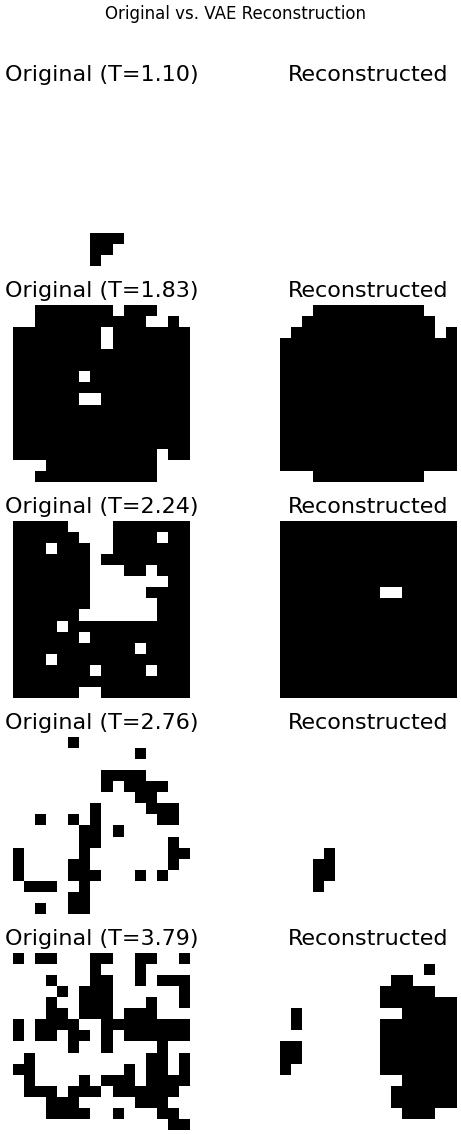

In [15]:
print("\nVisualizing Original vs. Reconstructed configurations...")

# Select 5 samples from different physical regimes
target_temps = [1.1, 1.8, 2.27, 2.8, 3.8] # Low T, below Tc, at Tc, above Tc, high T
selected_indices = [np.argmin(np.abs(ts - T_target)) for T_target in target_temps]

fig_recon, axes_recon = plt.subplots(len(selected_indices), 2, figsize=(6, 12))
fig_recon.suptitle("Original vs. VAE Reconstruction")

with torch.no_grad():
    for i, idx in enumerate(selected_indices):
        # Get the original configuration
        original_config_tensor = all_data_tensor[idx]
        temp_of_sample = ts[idx]

        # Get the reconstruction from the VAE
        reconstructed_config_tensor, _, _ = model(original_config_tensor.unsqueeze(0))

        # --- MODIFICATION START ---
        # The VAE outputs probabilities (values between 0 and 1).
        # We round them to the nearest integer (0 or 1) to get a binary configuration.
        thresholded_reconstruction = torch.round(reconstructed_config_tensor)
        # --- MODIFICATION END ---

        # Convert to numpy arrays for plotting (and back to {-1, 1} spins for visualization)
        original_np = (original_config_tensor.cpu().numpy().reshape(L, L) * 2 - 1)
        # Use the thresholded tensor for the reconstruction plot
        reconstructed_np = (thresholded_reconstruction.cpu().numpy().reshape(L, L) * 2 - 1)

        # Plot Original
        ax_orig = axes_recon[i, 0]
        ax_orig.imshow(original_np, cmap='gray', vmin=-1, vmax=1)
        ax_orig.set_title(f"Original (T={temp_of_sample:.2f})")
        ax_orig.axis('off')

        # Plot Reconstructed
        ax_recon = axes_recon[i, 1]
        ax_recon.imshow(reconstructed_np, cmap='gray', vmin=-1, vmax=1)
        ax_recon.set_title("Reconstructed")
        ax_recon.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle
plt.show()